<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/ArXivClassification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [9]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 1786, done.
remote: Counting objects: 100% (427/427), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 1786 (delta 330), reused 271 (delta 230), pack-reused 1359
Receiving objects: 100% (1786/1786), 27.85 MiB | 15.43 MiB/s, done.
Resolving deltas: 100% (945/945), done.
/content/ArXivClassification/ArXivClassification/ArXivClassification/ArXivClassification


# 1) Build the dataset

In [5]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [6]:
SEED = 42 # fix random seed for reproducibility
random.seed(SEED)

## 1.1 Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [7]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 49% 649M/1.28G [00:08<00:08, 83.5MB/s]
User cancelled operation


Unzip the downloaded file.

In [8]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

BadZipFile: File is not a zip file

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [ ]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

## 1.2 Get rid of some unnecessary infomation

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

Visualize the dataset distribution.

In [ ]:
# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

## 1.3 Keep 20 categories

In [ ]:
path = "./arxiv_data_filtered.csv"
df = pd.read_csv(path, dtype=str)
df.head()

In [ ]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # Keep only a subset of C.
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
check = lambda x: set(x).issubset(sub_C)
df = df.loc[df["category"].apply(check).loc[lambda x: x].index]
df = df.reset_index(drop=True)
df.head()

## 1.4 Remove categories with < m samples
First, find categories that have less than m samples, namely "categs_to_drop".
Then, keep articles whose lists of categories have no intersection with "categs_to_drop".


In [ ]:
m = 100
categs_to_drop = [categ for categ,count in dict_counts_exp.items() if count<m]

utils.categories_as_lists(df) # take "category" as a column of lists
has_no_intersection = lambda x: not (set(x) & set(categs_to_drop))
df = df.loc[df["category"].apply(has_no_intersection).loc[lambda x: x].index]

df = df.reset_index(drop=True)
print(f'Number of articles in the dataset: {len(df)}')
df.tail()

Visualize the dataset distribution.

In [ ]:
# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
_ = utils.plot_df_counts(df_exp, col="category")

# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")

# 2) Text-processing

In [50]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [51]:
import en_core_web_md
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [52]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
abs_cleaner = lambda x: utils.text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(abs_cleaner, axis=1)

# Then on titles.
tit_cleaner = lambda x: utils.text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(tit_cleaner, axis=1)

df.tail()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 18241/18241 [02:22<00:00, 128.03it/s]


,id,title,category,abstract,clean_abstract,clean_title
18236,2405.05896,A note on the volume entropy on a harmonic man...,['math.DG'],Harmonic manifolds of hypergeometric type fo...,harmonic manifold hypergeometric type form cla...,note volume entropy harmonic manifold hypergeo...
18237,2405.05960,The effects of bar strength and kinematics on ...,['astro-ph.GA'],We study how bar strength and bar kinematics...,study bar strength bar kinematic affect star f...,effect bar strength kinematic galaxy evolution...
18238,cond-mat/0403559,Quantum Dark Soliton: Non-Perturbative Diffusi...,['cond-mat.mes-hall'],The dark soliton solution of the Gross-Pitae...,dark soliton solution gross pitaevskii equatio...,quantum dark soliton non perturbative diffusio...
18239,cond-mat/0404352,Scaling dependence on time and distance in non...,['cond-mat.soft'],"Recently, fractional derivatives have been e...",recently fractional derivative employ analyze ...,scale dependence time distance nonlinear fract...
18240,math/0510057,Cryptography and Encryption,['math.CT'],"In cryptography, encryption is the process o...",cryptography encryption process obscure inform...,cryptography encryption


In [53]:
# Add a space to separate title and abstract.
df["clean_text"] = df["clean_title"] + " " + df["clean_abstract"]

# 3) Multilabel Classification
Given an article:
- its feature X will be the cleaned text
- its label y will be its lists of categories (in a one-hot-encoding)

In [10]:
!pip install scikit-multilearn
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.0 MB/s eta 0:00:00


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.svm import SVC, LinearSVC

from yellowbrick.classifier import ClassificationReport

## 3.1 Prepare features and labels.

In [12]:
path = "/content/dati_11_maggio_nosample.csv"
df = pd.read_csv(path, dtype=str)
print(len(df))
df.tail()

26209


,id,title,category,abstract,check,clean_abstract,clean_title,clean_text
26204,hep-ph/9806345,On positivity of parton distributions,['hep-ph'],We discuss the bounds on polarized parton di...,True,discuss bound polarize parton distribution fol...,positivity parton distribution,positivity parton distribution discuss bound p...
26205,math/0104025,On the Goedel's formula,['math.GM'],This article examines the formula G (of Goed...,True,article examine formula g goedel demonstrate g...,goedel formula,goedel formula article examine formula g goede...
26206,math/0305442,Adjoint and coadjoint orbits of the Poincar\'e...,['math.RT'],In this paper we give an effective method fo...,True,paper effective method find unique representat...,adjoint coadjoint orbit group,adjoint coadjoint orbit group paper effective ...
26207,math/0505619,Stabilization phenomena in Kac-Moody algebras ...,['math.RT'],Let X be the Dynkin diagram of a symmetrizab...,True,let x dynkin diagram symmetrizable kac moody a...,stabilization phenomena kac moody algebra quiv...,stabilization phenomena kac moody algebra quiv...
26208,math/0509562,Invariant bilinear differential operators,['math.RT'],I classified bilinear differential operators...,True,classify bilinear differential operator act sp...,invariant bilinear differential operator,invariant bilinear differential operator class...


In [41]:
# Preparing X (features).
X = df["clean_text"]
X = X.to_numpy()

# Preparing y (labels) in a one-hot encoding.
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding

# Visualize y
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.HE,astro-ph.SR,cond-mat.str-el,cs.NI,cs.RO,eess.IV,gr-qc,hep-ph,math.FA,math.GM,math.PR,math.RT,physics.ao-ph,physics.app-ph,physics.comp-ph,physics.soc-ph
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26204,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
26205,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
26206,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
26207,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## 3.2 Do the classification with the best train/test split.

In [ ]:
# !pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

msss = MultilabelStratifiedShuffleSplit(n_splits=30, test_size=0.3,
                                        random_state=SEED)

ovr = OneVsRestClassifier(LinearSVC(class_weight='balanced'),
                          n_jobs=-1)

model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', ovr)])

f0 = 0
best_f = 0
for train_index, test_index in msss.split(X, y):
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]
   y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                                 multilabel=True)

   f = f1_score(y_test, y_pred, average='weighted')
   print(f'f1_weighted = {round(f,3)}')

   if f>f0:
       best_f = f
       best_X_train, best_X_test = X_train, X_test
       best_y_train, best_y_test = y_train, y_test
       best_y_pred, best_mat = y_pred, mat

   f0 = best_f

print(f'best f1_weighted = {round(best_f,3)}\n')

f1_weighted = 0.912
f1_weighted = 0.912
f1_weighted = 0.905
f1_weighted = 0.913
f1_weighted = 0.911
f1_weighted = 0.907
f1_weighted = 0.91
f1_weighted = 0.909
f1_weighted = 0.903
f1_weighted = 0.907


## 3.2 Show results.

See the classification report.

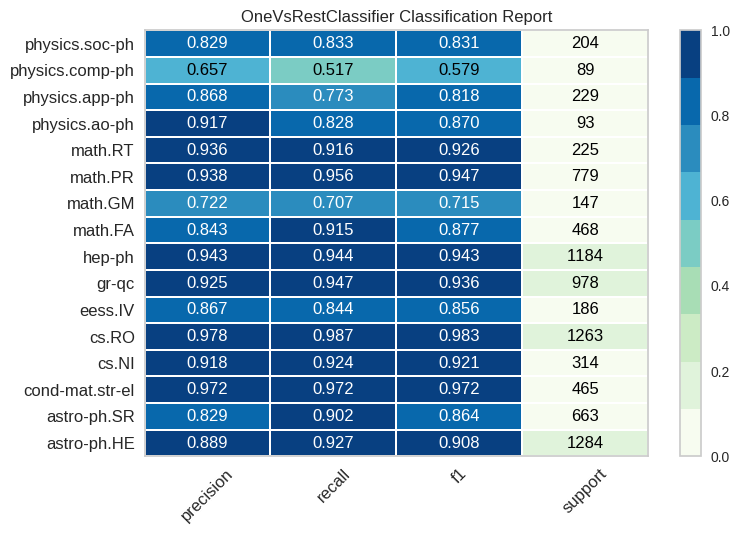

<Axes: title={'center': 'OneVsRestClassifier Classification Report'}>

In [32]:
visualizer = ClassificationReport(model, classes=classes, support=True, cmap='GnBu')
visualizer.fit(best_X_train, best_y_train)
visualizer.score(best_X_test, best_y_test) # evaluate the model on the test data
visualizer.show()

Plot confusion matrices.

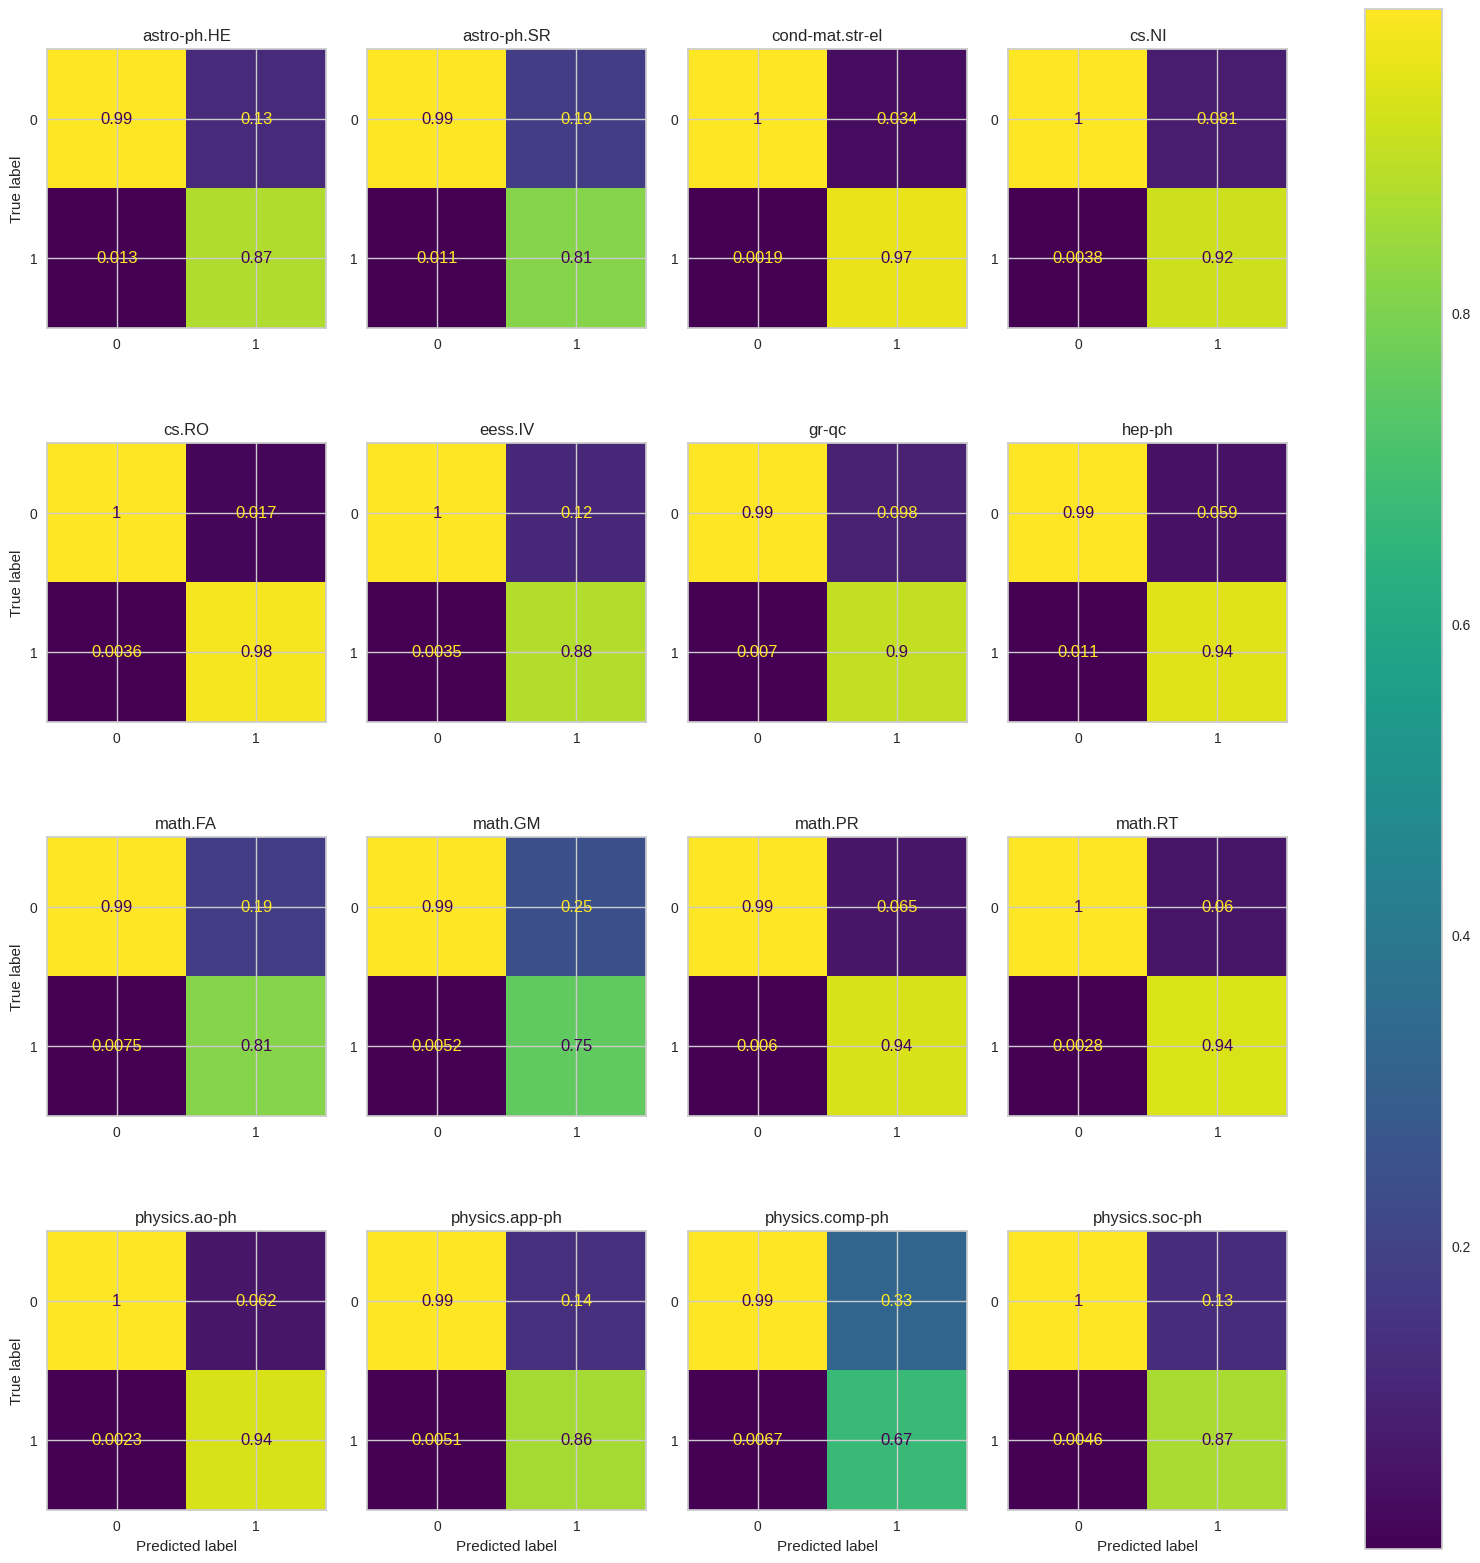

In [33]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [34]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('gr-qc',)
predicted: ('gr-qc',)
--------------------
  true   : ('math.GM',)
predicted: ()
--------------------
  true   : ('math.RT',)
predicted: ('math.RT',)
--------------------
  true   : ('math.PR',)
predicted: ('math.PR',)
--------------------
  true   : ('math.GM',)
predicted: ('math.GM',)
--------------------
  true   : ('gr-qc',)
predicted: ('gr-qc',)
--------------------
  true   : ('hep-ph',)
predicted: ('hep-ph',)
--------------------
  true   : ('hep-ph',)
predicted: ('hep-ph',)
--------------------
  true   : ('gr-qc',)
predicted: ('gr-qc', 'math.FA')
--------------------
  true   : ('math.GM',)
predicted: ('math.GM',)


Plot the ROC curve.

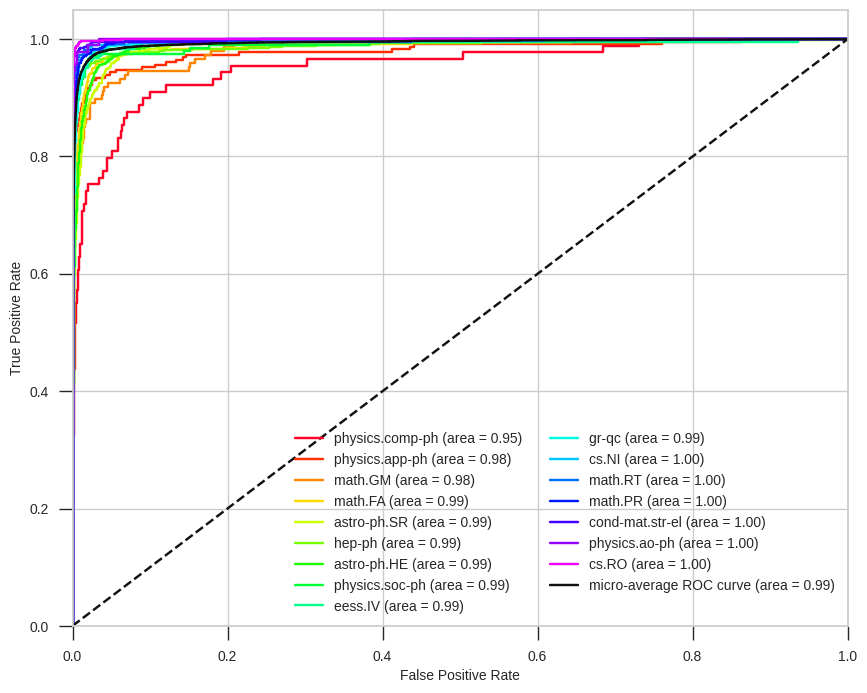

In [36]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

Plot the Precision-Recall curve.

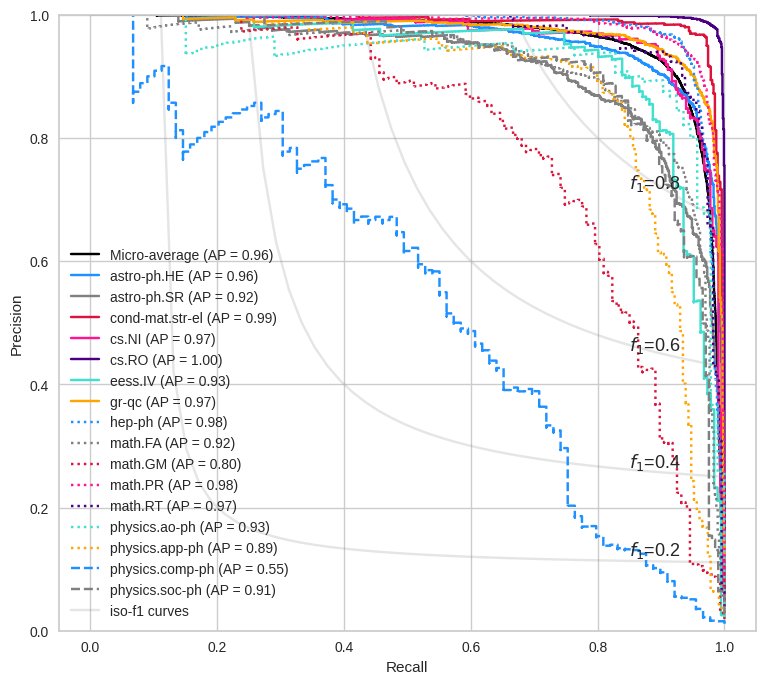

In [37]:
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from itertools import cycle
import numpy as np


# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i],
                                                   y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
                                                                y_score.ravel())
average_precision["micro"] = average_precision_score(y_test,
                                                     y_score,
                                                     average="micro")


colors = ["dodgerblue", "gray", "crimson", "deeppink",
          "indigo", "turquoise", "orange"]
num_colors = len(colors)
colorcyler = cycle(colors)

lines = ['-', ':', '--', '-.']
linecycler = cycle(lines)

_, ax = plt.subplots(figsize=(9, 8))
f_scores = np.linspace(0.2, 0.8, num=4)

lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("$f_1$={0:0.1f}".format(f_score),
                 xy=(0.85, y[45]+0.01),
                 fontsize=13)

display = PrecisionRecallDisplay(recall=recall["micro"],
                                 precision=precision["micro"],
                                 average_precision=average_precision["micro"])

display.plot(ax=ax, name="Micro-average", color="black")

linestyle = 'solid'
for i in range(len(classes)):
    display = PrecisionRecallDisplay(recall=recall[i],
                                     precision=precision[i],
                                     average_precision=average_precision[i])

    if not i % num_colors:
        linestyle = next(linecycler)

    color = next(colorcyler)
    display.plot(ax=ax, color=color, name=f"{classes[i]}", linestyle=linestyle)


# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])

# set the legend and the axes
ax.legend(handles=handles, labels=labels, loc="lower left")
ax.set_ylim(0,1)
plt.show()

# 4) Keywords extraction

In [66]:
!pip install KeyBERT -q
!pip install keyphrase-vectorizers -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.8 MB/s eta 0:00:00


In [67]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
kw_model = KeyBERT('all-mpnet-base-v2')

extraction = lambda x: utils.extract_kws(text=x["clean_text"],
                                         kw_model=kw_model,
                                         seed=x["clean_title"].split(" "))

df["keywords"] = df.progress_apply(extraction, axis=1)

df.to_csv(f"./keywords.csv", index=False) # Save to csv
df.head()

 26%|██▋       | 4807/18241 [07:50<1:16:33,  2.92it/s]

# 5) Multilabel Classification #2
Repeat the classification.
This time, given an article:
- its feature X will be the list of its keywords
- its label y will be its lists of categories (in a one-hot-encoding)


In [ ]:
# Preparing X (features).
X = df["keywords"].map(lambda x: " ".join(x))


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

In [ ]:
y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

Plot confusion matrices.

In [ ]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [ ]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

## 5.3 ROC curve and Precision-Recall curve

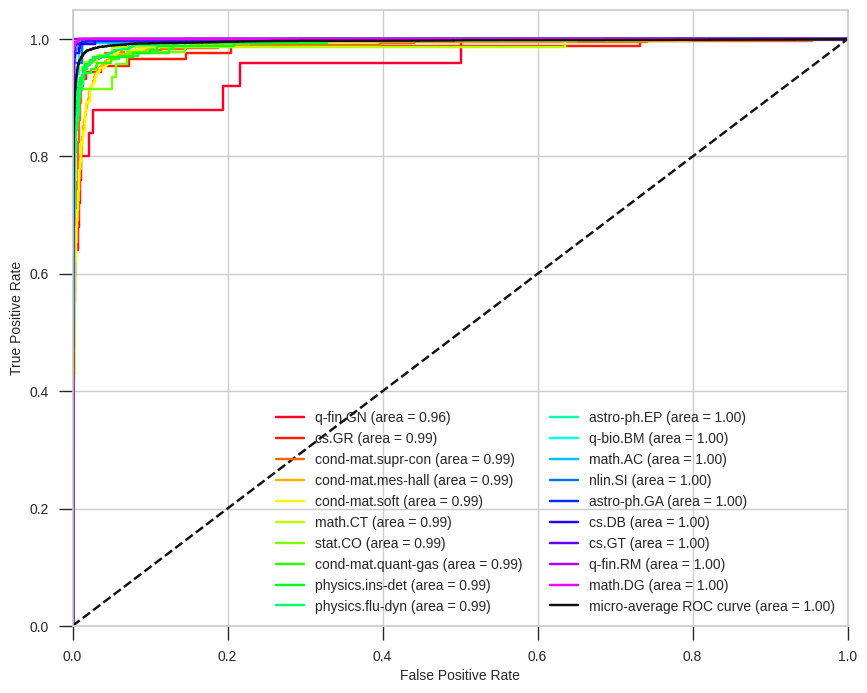

In [ ]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

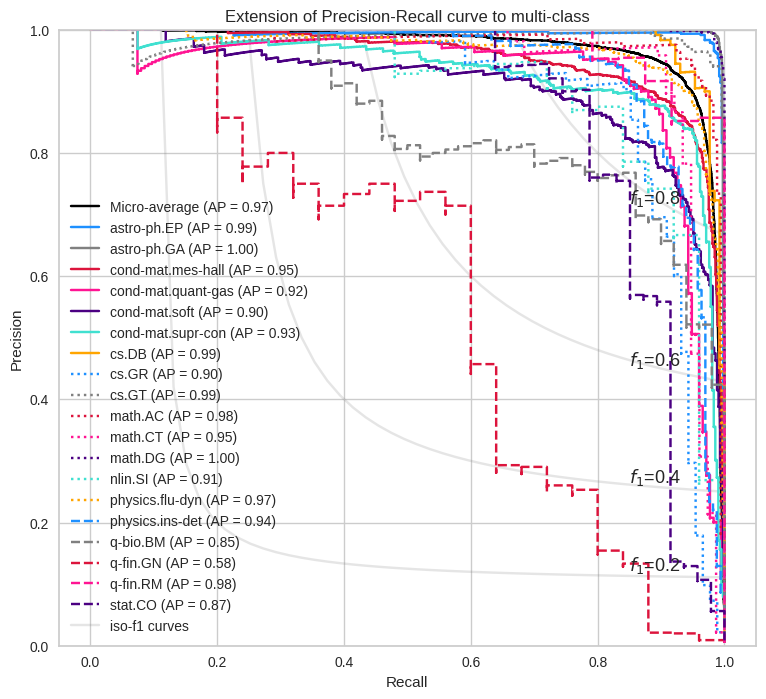

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from itertools import cycle
import numpy as np


# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i],
                                                   y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
                                                                y_score.ravel())
average_precision["micro"] = average_precision_score(y_test,
                                                     y_score,
                                                     average="micro")


colors = ["dodgerblue", "gray", "crimson", "deeppink",
          "indigo", "turquoise", "orange"]
num_colors = len(colors)
colorcyler = cycle(colors)

lines = ['-', ':', '--', '-.']
linecycler = cycle(lines)

_, ax = plt.subplots(figsize=(9, 8))
f_scores = np.linspace(0.2, 0.8, num=4)

lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("$f_1$={0:0.1f}".format(f_score),
                 xy=(0.85, y[45]+0.01),
                 fontsize=13)

display = PrecisionRecallDisplay(recall=recall["micro"],
                                 precision=precision["micro"],
                                 average_precision=average_precision["micro"])

display.plot(ax=ax, name="Micro-average", color="black")

linestyle = 'solid'
for i in range(len(classes)):
    display = PrecisionRecallDisplay(recall=recall[i],
                                     precision=precision[i],
                                     average_precision=average_precision[i])

    if not i % num_colors:
        linestyle = next(linecycler)

    color = next(colorcyler)
    display.plot(ax=ax, color=color, name=f"{classes[i]}", linestyle=linestyle)


# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])

# set the legend and the axes
ax.legend(handles=handles, labels=labels, loc="lower left")
ax.set_ylim(0,1)
plt.show()